## CapMetro Bus Stops VS Service Area Population Demographics Analysis

In [56]:
#import dependencies
from census import Census
from config import census_key, tamu_key
from us import states
import json
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import plotly
import plotly.graph_objects as go
import pprint
import requests
import scipy
from scipy import stats
from scipy import interpolate
import seaborn as sns
import shapely.wkt
from shapely.geometry import MultiPolygon, Polygon
import time
import warnings
warnings.filterwarnings('ignore')

## CapMetro Bus Stop Data

In [2]:
bus_stops_path = os.path.join("bus_stops.csv")
bus_stops_csv = pd.read_csv(bus_stops_path, header=0)
bus_stops_master_df = pd.DataFrame(bus_stops_csv)

In [3]:
bus_stops_df = bus_stops_master_df[["stop_name", "stop_lat", "stop_lon"]]

In [4]:
capmetro_bus_stops_df = bus_stops_df.rename(columns= {"stop_lat": "lat", "stop_lon": "lon"})

In [5]:
capmetro_bus_stops_df

,stop_name,lat,lon
0,Rio Grande/15th,30.278966,-97.746339
1,8740 Lamar/Payton Gin,30.356809,-97.701066
2,Fairfield Station (SB),30.355296,-97.703128
3,Lamar/Thurmond,30.353139,-97.706082
4,8320 Lamar/Meadowlark,30.352256,-97.707295
...,...,...,...
2406,Norwood Transit Center,30.340154,-97.691472
2407,10099 Burnet/Mc Hale,30.385221,-97.723575
2408,2007 Pleasant Valley/Riverside,30.233492,-97.724007
2409,MLK Jr Station,30.279442,-97.709643


## Texas A&M Reverse Geocoding API

In [13]:
version = "4.10"
url= "https://geoservices.tamu.edu/Services/ReverseGeocoding/WebService/v04_01/HTTP/default.aspx"

bus_stops_geocode = []

for lat, lon in zip(capmetro_bus_stops_df['lat'], capmetro_bus_stops_df['lon']):
    payload = {
        "apiKey": tamu_key,
        "version": version,
        "format": "json",
        "lat": lat,
        "lon": lon}

    r = requests.get(url, params= payload).json()
    bus_stops_geocode.append(r)

In [14]:
bus_zip_codes = []
for x in range(len(bus_stops_geocode)):
    bus_zip_code_result = bus_stops_geocode[x]["StreetAddresses"][0]["Zip"]
    bus_zip_codes.append(bus_zip_code_result)

In [15]:
capmetro_bus_stops_df["Zip_Codes"] = bus_zip_codes

In [16]:
capmetro_bus_stops_df["Zip_Codes"].unique()

array(['78701', '78753', '78757', '78752', '78751', '78705', '78704',
       '78745', '78744', '78721', '78702', '78756', '78703', '78741',
       '78723', '78722', '78724', '78749', '78731', '78759', '78746',
       '78754', '78758', '78735', '78736', '78748', '78645', '78727',
       '78617', '78750', '78729', '78717', '78660', '78728', '78641',
       '78621', '78613', '78747', '78653', '78737', '78739', '78664',
       '78681', '78665'], dtype=object)

In [17]:
capmetro_bus_stops_df

,stop_name,lat,lon,Zip_Codes
0,Rio Grande/15th,30.278966,-97.746339,78701
1,8740 Lamar/Payton Gin,30.356809,-97.701066,78753
2,Fairfield Station (SB),30.355296,-97.703128,78753
3,Lamar/Thurmond,30.353139,-97.706082,78753
4,8320 Lamar/Meadowlark,30.352256,-97.707295,78753
...,...,...,...,...
2406,Norwood Transit Center,30.340154,-97.691472,78753
2407,10099 Burnet/Mc Hale,30.385221,-97.723575,78758
2408,2007 Pleasant Valley/Riverside,30.233492,-97.724007,78741
2409,MLK Jr Station,30.279442,-97.709643,78702


In [18]:
capmetro_bus_stops_df.to_csv("bus_stops_zips.csv", index= False)

In [2]:
bus_path = os.path.join("bus_stops_zips.csv")
bus_df = pd.read_csv("bus_stops_zips.csv")

## Census API from the American Community Survey

In [3]:
c = Census(census_key , year=2017)

In [4]:
census_data = c.acs5.get(("B01003_001E", 
                          "B17001_002E",
                          "B08301_011E"),
                        {'for':'zip code tabulation area:*'})

census_pd = pd.DataFrame(census_data)

census_pd = census_pd.rename(columns={"B01003_001E":"Population",
                                      "B17001_002E": "Poverty_Count",
                                      "zip code tabulation area":"Zip_Codes",
                                      "B08301_011E": "Work_Pop_Bus"})

census_pd['Poverty_Rate'] = census_pd['Poverty_Count'].astype(int)/census_pd['Population'].astype(int) * 100
census_pd['Zip_Codes'] = census_pd['Zip_Codes'].astype(str).astype(int)

In [5]:
dataTypeObj = bus_df.dtypes['Zip_Codes']
master_df = pd.merge(census_pd, bus_df, on = 'Zip_Codes', how = 'inner')

## Master Dataframe

In [6]:
master_df

,Population,Poverty_Count,Work_Pop_Bus,Zip_Codes,Poverty_Rate,stop_name,lat,lon
0,77779.0,2943.0,210.0,78613,3.783798,ACC Cypress Creek,30.479477,-97.834422
1,27900.0,4815.0,149.0,78617,17.258065,Travis Correctional Facility,30.197840,-97.645546
2,27900.0,4815.0,149.0,78617,17.258065,3103 SH 71/Cheviot,30.205035,-97.642589
3,27900.0,4815.0,149.0,78617,17.258065,2777 SH 71/Golf Course,30.210895,-97.654067
4,27900.0,4815.0,149.0,78617,17.258065,3320 FM 973/SH 71,30.200884,-97.640493
...,...,...,...,...,...,...,...,...
2406,41847.0,2238.0,536.0,78759,5.348054,Braker/Mopac (Farside/Midblock),30.397553,-97.736066
2407,41847.0,2238.0,536.0,78759,5.348054,Esperanza Crossing/Domain,30.399880,-97.724385
2408,41847.0,2238.0,536.0,78759,5.348054,10001 Stonelake/Capital of Texas,30.391198,-97.739283
2409,41847.0,2238.0,536.0,78759,5.348054,Mopac/Braker,30.393962,-97.732447


## Contour Map Dataframe

In [7]:
contour_df = master_df[["Poverty_Rate", "stop_name", "lat", "lon"]]

In [8]:
contour_df.dropna(thresh=int(contour_df.shape[0] * .9), axis=1, inplace=True)

#convert latitude and longitude values to NumPy Arrays
lat = np.array(contour_df['lat'], dtype=float)
lon = np.array(contour_df['lon'], dtype=float)
poverty = np.array(contour_df['Poverty_Rate'], dtype=float)

In [9]:
#read in coordinate data pulled from data.austintexas.gov
austin_path = os.path.join("austin.csv")
austin = pd.read_csv('austin.csv')
austin

,the_geom,OBJECTID,JURISDICTIONS_ID,CITY_NAME,JURISDICTION_LABEL,MODIFIED_FIPS,JURISDICTION_TYPE_SPECIFICS,JURISDICTION_TYPE,Shape__Area,Shape__Length
0,MULTIPOLYGON (((-97.835007783852 30.2980755155...,209,133,CITY OF AUSTIN,AUSTIN LTD,211,LIMITED PURPOSE PLANNING ZONING HEALTH SAFETY,LTD,1.829295e+06,9422.603500
1,MULTIPOLYGON (((-97.821982860402 30.3402980711...,100,467,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,1.116094e+06,5107.203192
2,MULTIPOLYGON (((-97.829183244603 30.3651655160...,428,400359621,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,2.921849e+07,30032.188879
3,MULTIPOLYGON (((-97.763973193996 30.4753309076...,401,439,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,6.766228e+07,61785.580474
4,MULTIPOLYGON (((-97.778155988634 30.3927488743...,94,156,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,4.509143e+05,2950.287054
...,...,...,...,...,...,...,...,...,...,...
194,MULTIPOLYGON (((-97.56334531696 30.30385652219...,400,375,CITY OF AUSTIN,AUSTIN LTD,211,LIMITED PURPOSE PLANNING ZONING,LTD,7.938176e+07,46744.266126
195,MULTIPOLYGON (((-97.628028128668 30.3543323626...,495,400630281,CITY OF AUSTIN,AUSTIN FULL PURPOSE,210,FULL PURPOSE,FULL,7.162866e+06,13028.978932
196,MULTIPOLYGON (((-97.699860938373 30.1327892144...,221,540,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,7.595161e+06,14031.611794
197,MULTIPOLYGON (((-97.716368653205 30.1331554896...,276,544,CITY OF AUSTIN,AUSTIN 2 MILE ETJ,202,2 MILE ETJ,2MILE,1.087012e+05,1487.502390


In [10]:
#pull the geomtry column of resulting dataframe to get multipolygon of 
#austin city limit coordinates
geom = austin['the_geom'][184]

#parse coordinates into workable data type using parse as a shapely method
A = shapely.wkt.loads(geom)

#separate the lon & lat into xx and yy respestively and grab the exterior
#and not the inside of the shape
xx, yy = A[0].exterior.xy

## CapMetro Bus Stops with Poverty Rate Contour

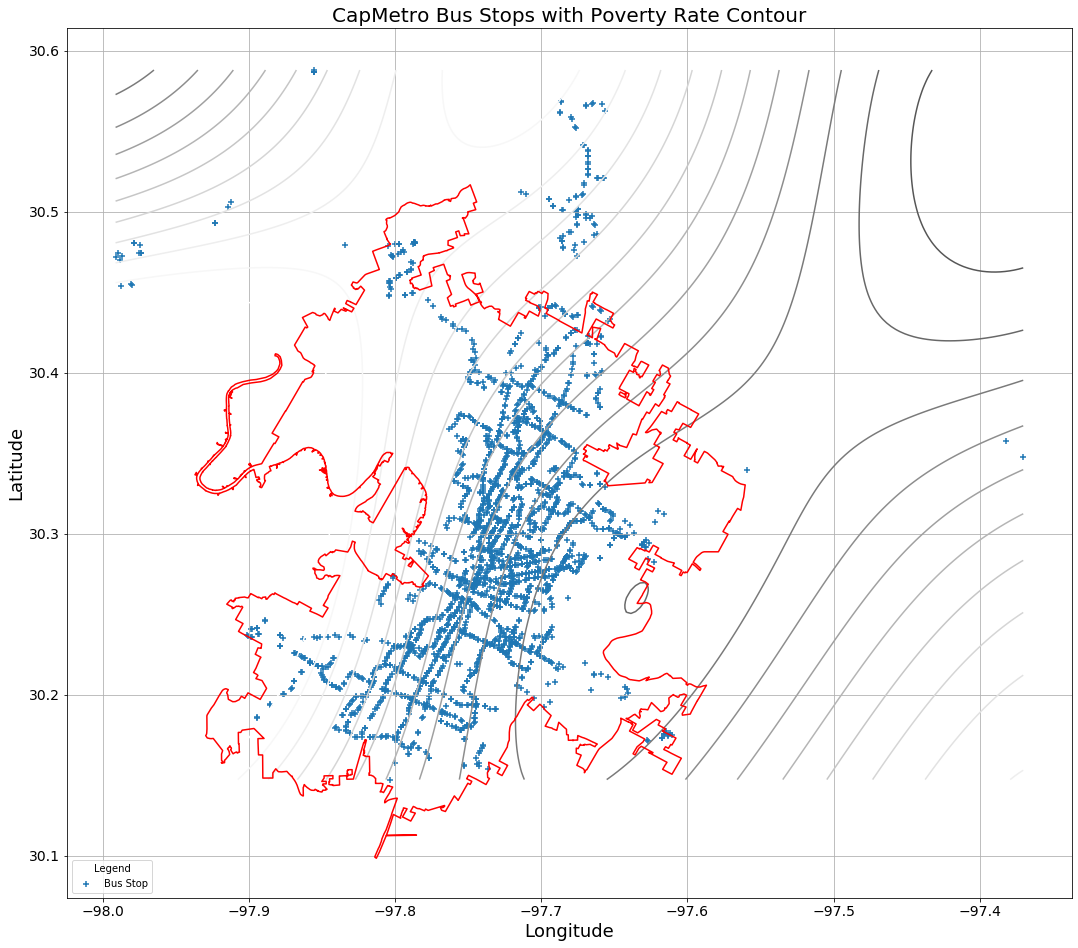

In [53]:
average_poverty = np.average(poverty)

lon_fake = -97.7 + 0.5 * np.cos(np.linspace(0, 2.0 * np.pi, 100))
lat_fake = 30.3 + 0.5 * np.sin(np.linspace(0, 2.0 * np.pi, 100))

f = interpolate.interp2d(
    np.concatenate((lon, lon_fake)),
    np.concatenate((lat, lat_fake)),
    np.concatenate((poverty, average_poverty * np.ones((100,)))),
    kind='cubic'
)
x = np.linspace(np.min(lon), np.max(lon), 200)
y = np.linspace(np.min(lat), np.max(lat), 200)
z = f(x, y)

matplotlib.rc('axes', titlesize= 20)
matplotlib.rc('axes', labelsize= 18)
matplotlib.rc('xtick', labelsize= 14)
matplotlib.rc('ytick', labelsize= 14)

plt.figure(figsize=(18,16))

plt.contour(x, y, z, levels= np.linspace(0, 40, 16), cmap= "Greys")

plt.scatter(lon, lat, marker= '+', label= "Bus Stop")

plt.plot(xx, yy, color= 'r')

plt.grid(True)

plt.legend(title= "Legend", loc= "lower left")
plt.title("CapMetro Bus Stops with Poverty Rate Contour")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
           
plt.savefig("Contour_Map.png")

plt.show()
plt.close()

## Scatter Plots DataFrame

In [29]:
zip_code_data = master_df.loc[:, ["Zip_Codes", "Poverty_Count", "Work_Pop_Bus", "Poverty_Rate", "Population"]].drop_duplicates()
bus_stop_count = master_df.groupby('Zip_Codes').count()['stop_name']

plot_data = pd.merge(bus_stop_count, zip_code_data, on = ('Zip_Codes','Zip_Codes'), how = 'inner')

plot_data.columns= ["Zip_Codes","Bus_Stop_Quantity","Poverty_Count", "Work_Pop_Bus", "Poverty_Rate", "Population"]

df = plot_data
df.head()

,Zip_Codes,Bus_Stop_Quantity,Poverty_Count,Work_Pop_Bus,Poverty_Rate,Population
0,78613,1,2943.0,210.0,3.783798,77779.0
1,78617,22,4815.0,149.0,17.258065,27900.0
2,78621,2,3447.0,0.0,15.484480,22261.0
3,78641,4,3892.0,163.0,6.472104,60135.0
4,78645,17,741.0,36.0,6.921999,10705.0


## Number of Bus Stops vs. CapMetro Service Area Population

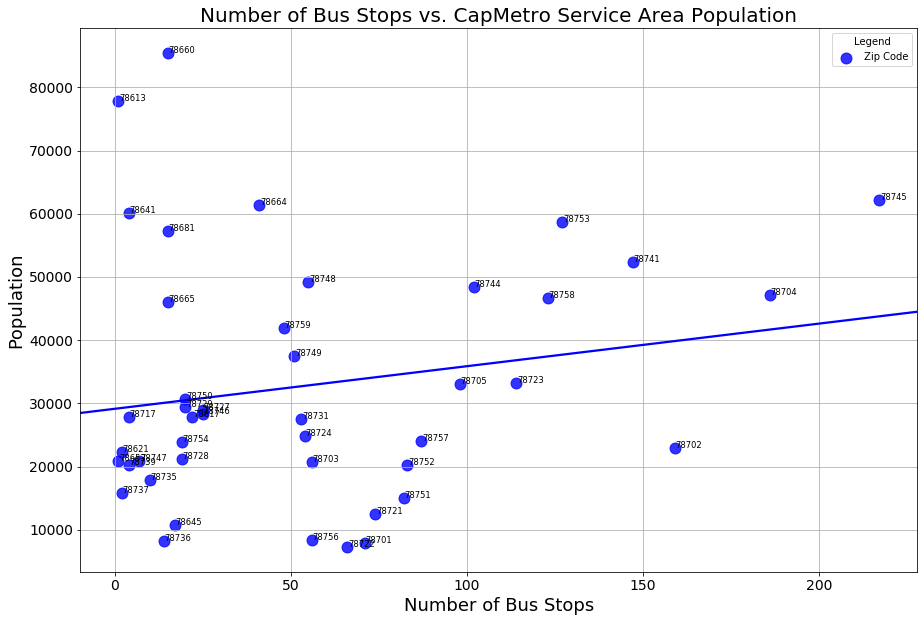

In [49]:
plt.figure(figsize = (15,10))

pop_plot = sns.regplot(data= df, x= "Bus_Stop_Quantity", y= "Population", marker= "o", scatter_kws={'s':120}, ci=None, label= "Zip Code", color= "#0000ff")

# add annotations one by one with a loop
for line in range(0, df.shape[0]):
     pop_plot.text(df.Bus_Stop_Quantity[line] + 0.2, df.Population[line], df.Zip_Codes[line], horizontalalignment= 'left', size= 'small', color= "black")

plt.grid()
plt.legend(title= "Legend", loc= "upper right")
plt.title("Number of Bus Stops vs. CapMetro Service Area Population")
plt.xlabel("Number of Bus Stops")
plt.ylabel("Population")
           
plt.savefig("Bus_Stop_VS_Population.png")

plt.show()
plt.close()

## Number of Bus Stops vs. Poverty Rate in CapMetro Service Area Zip Codes

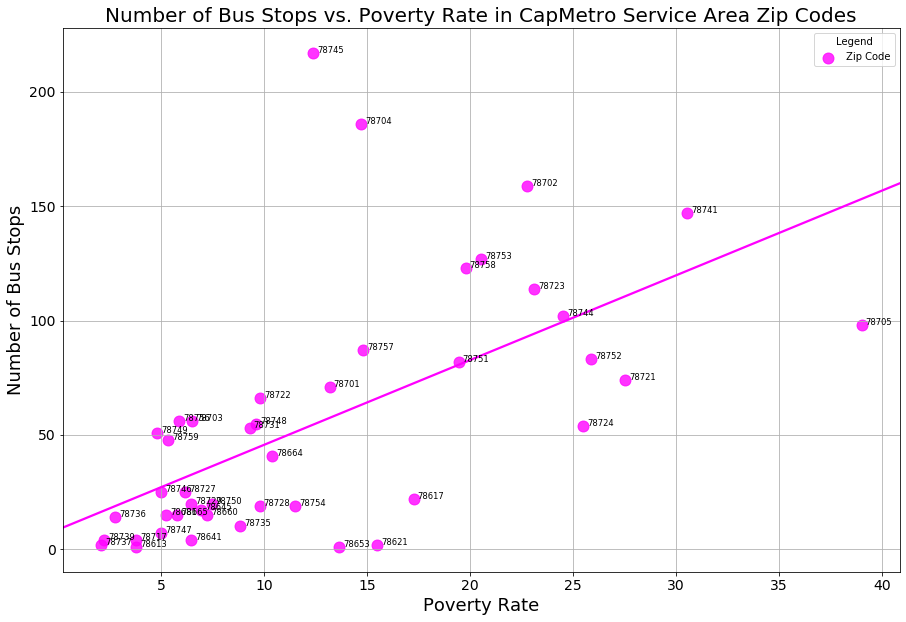

In [48]:
plt.figure(figsize = (15,10))

poverty_rate_plot = sns.regplot(data= df, x= "Poverty_Rate", y= "Bus_Stop_Quantity", marker= "o", scatter_kws={'s':120}, ci=None, label= "Zip Code", color= "#ff00ff")

# add annotations one by one with a loop
for line in range(0, df.shape[0]):
     poverty_rate_plot.text(df.Poverty_Rate[line] + 0.2, df.Bus_Stop_Quantity[line], df.Zip_Codes[line], horizontalalignment= 'left', size= 'small', color= "black")

plt.grid()
plt.legend(title= "Legend", loc= "upper right")
plt.title("Number of Bus Stops vs. Poverty Rate in CapMetro Service Area Zip Codes")
plt.xlabel("Poverty Rate")
plt.ylabel("Number of Bus Stops")
           
plt.savefig("Bus_Stop_VS_Poverty_Rate.png")

plt.show()
plt.close()

## Number of Bus Commuters  vs. Poverty Count

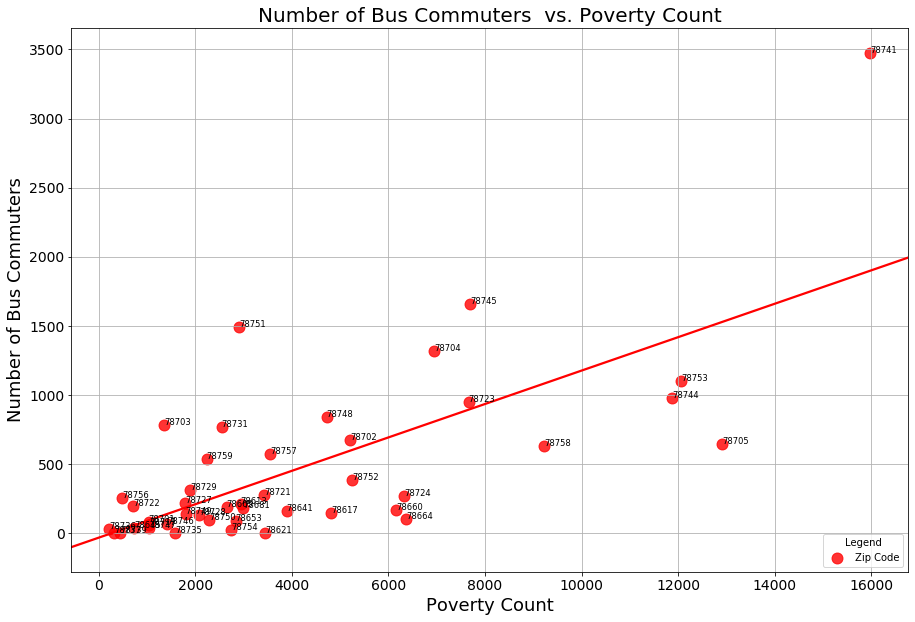

In [54]:
plt.figure(figsize = (15,10))
poverty_count_plot = sns.regplot(data= df, x= "Poverty_Count", y= "Work_Pop_Bus", marker= "o", scatter_kws={'s':120}, ci=None, label= "Zip Code", color= "#ff0000")

# add annotations one by one with a loop
for line in range(0, df.shape[0]):
     poverty_count_plot.text(df.Poverty_Count[line] + 0.2, df.Work_Pop_Bus[line], df.Zip_Codes[line], horizontalalignment= 'left', size= 'small', color= "black")

plt.grid()
plt.legend(title= "Legend", loc= "lower right")
plt.title("Number of Bus Commuters  vs. Poverty Count")
plt.xlabel("Poverty Count")
plt.ylabel("Number of Bus Commuters")
           
plt.savefig("Poverty_Count_VS_Bus_Riders.png")

plt.show()
plt.close()

## Number of Bus Commuters vs. Number of Bus Stops

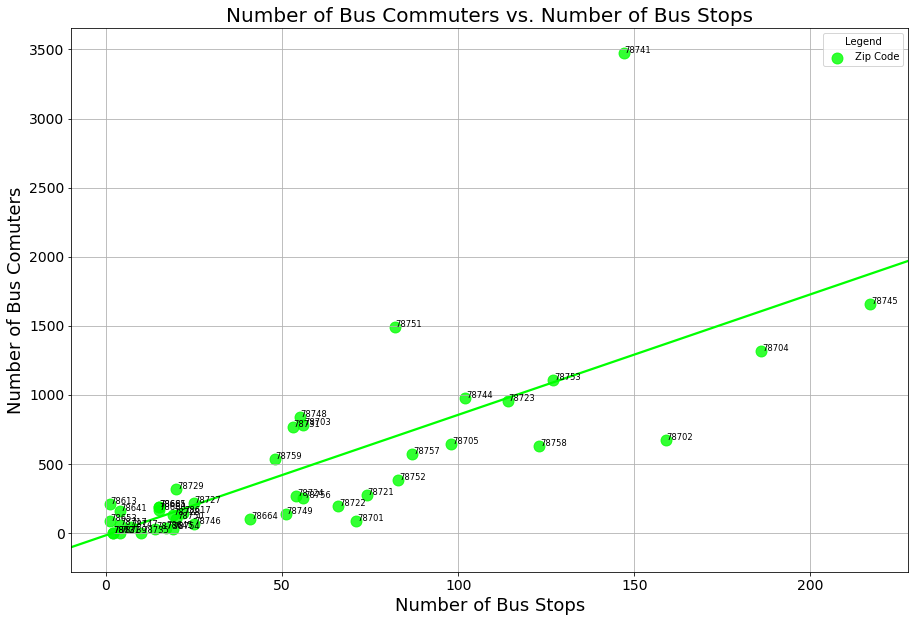

In [55]:
plt.figure(figsize = (15,10))
bus_plot = sns.regplot(data= df, x= "Bus_Stop_Quantity", y= "Work_Pop_Bus", marker= "o", scatter_kws={'s':120}, ci=None, label= "Zip Code", color= "#00ff00")
# add annotations one by one with a loop
for line in range(0, df.shape[0]):
   bus_plot.text(df.Bus_Stop_Quantity[line] + 0.2, df.Work_Pop_Bus[line], df.Zip_Codes[line], horizontalalignment= 'left', size= 'small', color= "black")
plt.grid()
plt.legend(title= "Legend", loc= "upper right")
plt.title("Number of Bus Commuters vs. Number of Bus Stops")
plt.xlabel("Number of Bus Stops")
plt.ylabel("Number of Bus Comuters")
      
plt.show()
plt.close()